In [5]:
from os import listdir
from nltk.corpus import stopwords
from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [6]:
#Load a single document
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [7]:
#Clean the document : Returns tokens
def clean_doc(doc):
    tokens = doc.split()
    table = str.maketrans('','',punctuation)
    tokens = [w.translate(table) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [word for word in tokens if len(word)>1]
    return tokens

In [8]:
def add_doc_to_vocab(filename,vocab):
    doc = load_doc(filename)
    tokens = clean_doc(doc)
    vocab.update(tokens)

In [9]:
def process_docs(directory, vocab):
    for filename in listdir(directory):
        if not filename.endswith('.txt'):
            continue
        path = directory+'/'+filename
        add_doc_to_vocab(path, vocab)

In [10]:
vocab = Counter()
process_docs('txt_sentoken/neg', vocab)
process_docs('txt_sentoken/pos', vocab)

In [11]:
#Drop tokens with low occurence
min_occurance = 5
tokens = [k for k,c in vocab.items() if c>=min_occurance]

In [12]:
def save_list(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [13]:
save_list(tokens,'vocab.txt')

In [14]:
#Writing to dataframe

In [15]:
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)

In [16]:
# load doc, clean and return line of tokens
def doc_to_line(filename, vocab):
    doc = load_doc(filename)
    tokens = clean_doc(doc)
    tokens = [w for w in tokens if w in vocab]
    return ' '.join(tokens)

In [17]:
#Load the reviews to pandas
def get_line(directory,vocab,target):
    lines = []
    churn = []
    for filename in listdir(directory):
        if not filename.endswith(".txt"):
            continue
        path = directory+'/'+filename
        line = doc_to_line(path,vocab)
        lines.append(line)
        churn.append(target)
    return lines,churn

In [18]:
negative_lines,negative_churn = get_line('txt_sentoken/neg', vocab, 0)

In [19]:
positive_lines, positive_churn = get_line('txt_sentoken/pos', vocab, 1)

In [20]:
df = pd.DataFrame({"text": negative_lines+positive_lines,"target":negative_churn+positive_churn})

In [21]:
df.head()

,target,text
0,0,senseless marlon wayans talented physical come...
1,0,last summer featurelength version avengers hit...
2,0,synopsis mentally unstable man saves boy poten...
3,0,film features richard lynch role chief villain...
4,0,inner flag last year nick pulled dragnet rerun...


In [22]:
df.shape

(2000, 2)

In [23]:
#Using TFID
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [24]:
tfidfconverter = TfidfVectorizer(max_features=2000,min_df=5,max_df=0.7,stop_words=stopwords.words('english'))
X = tfidfconverter.fit_transform(negative_lines+positive_lines).toarray()

In [25]:
y = negative_churn+positive_churn

In [26]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [32]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [27]:
#Sklearn imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

In [28]:
text_classifier = RandomForestClassifier(n_estimators=100,random_state=0)
text_classifier.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

The accuracy is :0.815


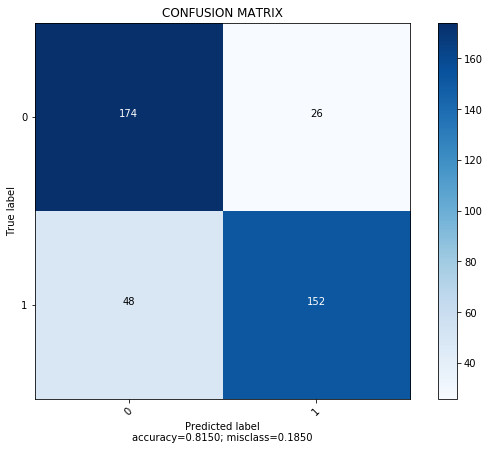

In [34]:
predictions = text_classifier.predict(X_test)
accuracy = text_classifier.score(X_test,y_test)
print('The accuracy is :'+str(accuracy))
cm = confusion_matrix(y_test,predictions)
plot_confusion_matrix(cm,normalize=False,target_names=['0','1'],title='CONFUSION MATRIX')

In [30]:
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

The accuracy is :0.84


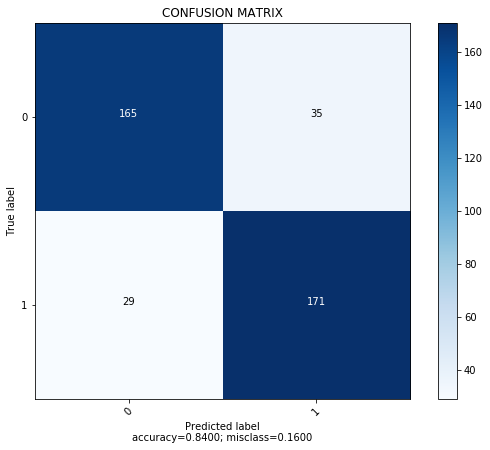

In [35]:
y_pred = svclassifier.predict(X_test)
accuracy = svclassifier.score(X_test,y_test)
print('The accuracy is :'+str(accuracy))
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm,normalize=False,target_names=['0','1'],title='CONFUSION MATRIX')

In [38]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.layers.core import Activation,Dropout
from keras.preprocessing.text import Tokenizer,one_hot
from keras.layers import GlobalMaxPooling1D
from keras.layers import Conv1D,LSTM
from numpy import array
from numpy import asarray
from numpy import zeros

Using TensorFlow backend.


In [39]:
X = negative_lines+positive_lines
Y = np.array(negative_churn+positive_churn)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=42)

In [40]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [41]:
#Adding one because of reserved zero index
vocab_size = len(tokenizer.word_index)+1
max_len = 100

X_train = pad_sequences(X_train,padding='post', maxlen=max_len)
X_test = pad_sequences(X_test,padding='post',maxlen=max_len)

In [42]:
embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding='utf-8')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [43]:
embedding_matrix = zeros((vocab_size,100))
for word,index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [44]:
#Creating the neural networks
model = Sequential()
embedding_layer = Embedding(vocab_size,100,weights=[embedding_matrix],input_length=max_len, trainable=False)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))

In [45]:
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1475600   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10001     
Total params: 1,485,601
Trainable params: 10,001
Non-trainable params: 1,475,600
_________________________________________________________________
None


In [46]:
history = model.fit(X_train,y_train,batch_size=128,epochs=20,verbose=1,validation_split=0.2)

Train on 1280 samples, validate on 320 samples
Epoch 1/20
1280/1280 [==============================] - 0s 377us/step - loss: 0.7678 - acc: 0.5141 - val_loss: 0.8036 - val_acc: 0.4844
Epoch 2/20
1280/1280 [==============================] - 0s 41us/step - loss: 0.5559 - acc: 0.7305 - val_loss: 0.7179 - val_acc: 0.5594
Epoch 3/20
1280/1280 [==============================] - 0s 44us/step - loss: 0.4457 - acc: 0.8453 - val_loss: 0.6791 - val_acc: 0.5969
Epoch 4/20
1280/1280 [==============================] - 0s 56us/step - loss: 0.3671 - acc: 0.9219 - val_loss: 0.6671 - val_acc: 0.6062
Epoch 5/20
1280/1280 [==============================] - 0s 40us/step - loss: 0.3033 - acc: 0.9594 - val_loss: 0.6714 - val_acc: 0.6094
Epoch 6/20
1280/1280 [==============================] - 0s 36us/step - loss: 0.2584 - acc: 0.9789 - val_loss: 0.6706 - val_acc: 0.6125
Epoch 7/20
1280/1280 [==============================] - 0s 45us/step - loss: 0.2225 - acc: 0.9898 - val_loss: 0.6749 - val_acc: 0.6094
Epoch 8

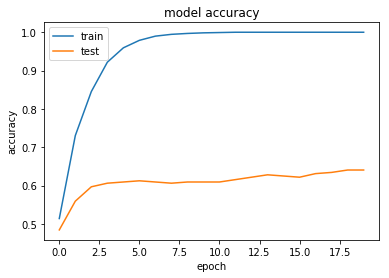

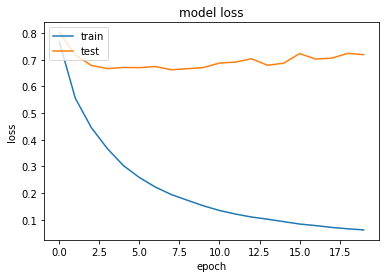

In [47]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [53]:
y_hat = model.predict(X_test)
cm = confusion_matrix(np.array(y_test).argmax(axis=1),np.array(y_hat).argmax(axis=1))
plot_confusion_matrix(cm,normalize=False,target_names=['0','1'],title='CONFUSION MATRIX')

AxisError: axis 1 is out of bounds for array of dimension 1

In [49]:
model = Sequential()

embedding_layer = Embedding(vocab_size,100,weights=[embedding_matrix],input_length=max_len,trainable=False)
model.add(embedding_layer)
model.add(Conv1D(128,5,activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['acc'])

In [50]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1475600   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,539,857
Trainable params: 64,257
Non-trainable params: 1,475,600
_________________________________________________________________
None


In [51]:
history = model.fit(X_train,y_train,batch_size=128,epochs=6,verbose=1,validation_split=0.2)
score = model.evaluate(X_test,y_test,verbose=1)

Train on 1280 samples, validate on 320 samples
Epoch 1/6
1280/1280 [==============================] - 2s 2ms/step - loss: 0.6748 - acc: 0.5687 - val_loss: 0.6543 - val_acc: 0.6000
Epoch 2/6
1280/1280 [==============================] - 1s 1ms/step - loss: 0.5421 - acc: 0.8133 - val_loss: 0.6518 - val_acc: 0.6250
Epoch 3/6
1280/1280 [==============================] - 1s 1ms/step - loss: 0.4729 - acc: 0.8523 - val_loss: 0.6327 - val_acc: 0.6531
Epoch 4/6
1280/1280 [==============================] - 1s 1ms/step - loss: 0.4124 - acc: 0.9227 - val_loss: 0.6433 - val_acc: 0.6406
Epoch 5/6
1280/1280 [==============================] - 1s 1ms/step - loss: 0.3723 - acc: 0.9414 - val_loss: 0.6397 - val_acc: 0.6438
Epoch 6/6
400/400 [==============================] - 0s 405us/step


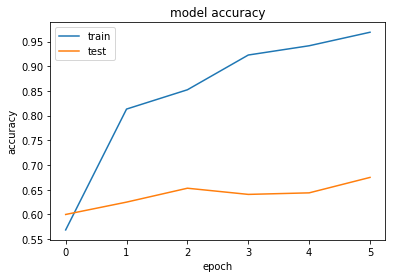

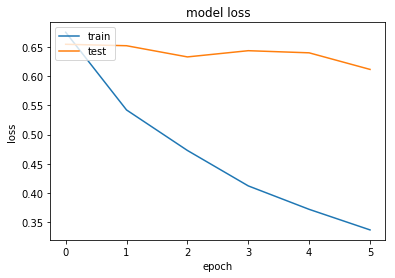

In [52]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [53]:
#Building a RNN
model = Sequential()
embedding_layer = Embedding(vocab_size,100,weights=[embedding_matrix],input_length=max_len,trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['acc'])

In [54]:
model.fit(X_train,y_train,batch_size=16,epochs=10)
score = model.evaluate(X_test,y_test,batch_size=16)

Epoch 1/10
1600/1600 [==============================] - 19s 12ms/step - loss: 0.6688 - acc: 0.5900
Epoch 2/10
1600/1600 [==============================] - 16s 10ms/step - loss: 0.5932 - acc: 0.6863
Epoch 3/10
1600/1600 [==============================] - 17s 11ms/step - loss: 0.5259 - acc: 0.7369
Epoch 4/10
1600/1600 [==============================] - 18s 11ms/step - loss: 0.4957 - acc: 0.7650
Epoch 5/10
1600/1600 [==============================] - 19s 12ms/step - loss: 0.4627 - acc: 0.7794
Epoch 6/10
1600/1600 [==============================] - 26s 16ms/step - loss: 0.4337 - acc: 0.7900
Epoch 7/10
1600/1600 [==============================] - 18s 11ms/step - loss: 0.3888 - acc: 0.8200
Epoch 8/10
1600/1600 [==============================] - 18s 11ms/step - loss: 0.3231 - acc: 0.8575
Epoch 9/10
1600/1600 [==============================] - 18s 11ms/step - loss: 0.2853 - acc: 0.8812
Epoch 10/10
400/400 [==============================] - 1s 2ms/step
